 Text spam model code

In [1]:
# -*- coding:UTF-8 -*-
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function
# 
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Dropout, GRU
from keras.models import Model
from keras.optimizers import RMSprop,SGD
from keras.callbacks import ModelCheckpoint
from keras import regularizers
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"



BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
# Read the text dataset path
TEXT_DATA_DIR = os.path.join(BASE_DIR, '')
print(TEXT_DATA_DIR)
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 200

nb_filters = 256
hiden_lstm_layer = 256

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {'ham':0, 'spam':1}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
                        
count = 0
for folder in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, folder)
    for fname in sorted(os.listdir(path)):
        if fname is not None:
            fpath = os.path.join(path, fname)
            args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
            with open(fpath, **args) as f:
                t = f.read()
                i = t.find('Subject:')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                count+=1
                print(count,":",t[0:30])
            if folder =='ham':
                labels.append(0)
                print('ham')
            else:
                labels.append(1)
                print('spam')
# print('Process text dataset done')
# print('count:',count)


Using TensorFlow backend.


/home/zsj/luoyang/spam_final/spam-experiment-paper/text_email_dataset/
Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
1 : Subject: re : quasi
good morni
ham
2 : Subject: enrononline desk to d
ham
3 : Subject: david gray
bill ,
is 
ham
4 : Subject: re : monday blues
goo
ham
5 : Subject: monday blues
bill ,
i
ham
6 : Subject: wednesday enpower cle
ham
7 : Subject: next wednesday ' s in
ham
8 : Subject: re : weights ? nice .
ham
9 : Subject: re : weights ? nice .
ham
10 : Subject: yummy frappachino
hey
ham
11 : Subject: re : no java ?
you ar
ham
12 : Subject: no java ?
bill ,
how 
ham
13 : Subject: volleyball
we are in 
ham
14 : Subject: celebrate responsibly
ham
15 : Subject: ncpa br is back
hey g
ham
16 : Subject: dave porter
was dave 
ham
17 : Subject: vacation payback
leaf
ham
18 : Subject: drug test
bill -
as i
ham
19 : Subject: out of office
i will 
ham
20 : Subject: data at your fingerti
ham
21 : Subject: 2001 summer assessmen
ham
22 : Subject: quarterly 

645 : Subject: caiso notification - 
ham
646 : Subject: re : august hourly bl
ham
647 : Subject: caiso notification - 
ham
648 : Subject: fw : august hourly bl
ham
649 : Subject: prior month adjustmen
ham
650 : Subject: re : e - request 5359
ham
651 : Subject: lp deal
bill -
please
ham
652 : Subject: fw : august hourly bl
ham
653 : Subject: fw : bloomberg hourly
ham
654 : Subject: happy birthday
bill -
ham
655 : Subject: coi rating change heo
ham
656 : Subject: organizational announ
ham
657 : Subject: fw : busy day with th
ham
658 : Subject: re : e - request 5359
ham
659 : Subject: re - rates
after the 
ham
660 : Subject: first game this sunda
ham
661 : Subject: revised stwhoulry pma
ham
662 : Subject: re : prior month adju
ham
663 : Subject: fw : request submitte
ham
664 : Subject: testing psw and path 
ham
665 : Subject: testing the psw and p
ham
666 : Subject: re : caiso overview -
ham
667 : Subject: eol data for august 6
ham
668 : Subject: ken :
confirming our 
ham
669 : Subject: c

1483 : Subject: schedule crawler : ho
ham
1484 : Subject: start date : 2 / 5 / 
ham
1485 : Subject: schedule crawler : ho
ham
1486 : Subject: start date : 2 / 5 / 
ham
1487 : Subject: start date : 2 / 5 / 
ham
1488 : Subject: start date : 2 / 5 / 
ham
1489 : Subject: start date : 2 / 5 / 
ham
1490 : Subject: start date : 2 / 5 / 
ham
1491 : Subject: start date : 2 / 4 / 
ham
1492 : Subject: schedule crawler : ho
ham
1493 : Subject: start date : 2 / 6 / 
ham
1494 : Subject: start date : 2 / 6 / 
ham
1495 : Subject: start date : 2 / 6 / 
ham
1496 : Subject: start date : 2 / 6 / 
ham
1497 : Subject: start date : 2 / 5 / 
ham
1498 : Subject: start date : 2 / 6 / 
ham
1499 : Subject: start date : 2 / 7 / 
ham
1500 : Subject: start date : 2 / 6 / 
ham
1501 : Subject: adv : space saving co
spam
1502 : Subject: fw : account over due
spam
1503 : Subject: miningnews . net news
spam
1504 : Subject: say goodbye to long d
spam
1505 : Subject: when sp @ m doesn ' t
spam
1506 : Subject: new clonazepa

2238 : Subject: rx : cialus , levitra
spam
2239 : Subject: regretting toodle
my 
spam
2240 : Subject: extreme content viola
spam
2241 : Subject: paliourg , best meds

spam
2242 : Subject: this is it - - 28
284
spam
2243 : Subject: visit our internet ph
spam
2244 : Subject: wife not happy ?
* pr
spam
2245 : Subject: algae
mathews ,
goven
spam
2246 : Subject: cannot buttonhole bra
spam
2247 : Subject: your barclays ibank a
spam
2248 : Subject: win a turbocharged ja
spam
2249 : Subject: palladia
prather ,
on
spam
2250 : Subject: monthly investment ne
spam
2251 : Subject: congratulation for wi
spam
2252 : Subject: fw : fw : xx 3 nical 
spam
2253 : Subject: here ' s that stock t
spam
2254 : Subject: be big like a black g
spam
2255 : Subject: hi paliourg got all p
spam
2256 : Subject: hi paliourg have pill
spam
2257 : Subject: hi paliourg need meds
spam
2258 : Subject: if yours never get lo
spam
2259 : Subject: men s . , e , x 10 ti
spam
2260 : Subject: visit our internet ph
spam
2261 : Subj

spam
3107 : Subject: re : info you request
spam
3108 : Subject: cialis , valium , via
spam
3109 : Subject: earn 100 k in the nex
spam
3110 : Subject: hot wifes
click here 
spam
3111 : Subject: shes giving himhand
c
spam
3112 : Subject: have yous seen how lo
spam
3113 : Subject: meds on - line
hey ,

spam
3114 : Subject: 

spam
3115 : Subject: notebookplus - carryi
spam
3116 : Subject: prozac , viagra , cia
spam
3117 : Subject: reply : best sexy car
spam
3118 : Subject: we need your updated 
spam
3119 : Subject: roud and huge
click h
spam
3120 : Subject: get this awesome sony
spam
3121 : Subject: mom and daughter play
spam
3122 : Subject: medical post : new an
spam
3123 : Subject: our track record prov
spam
3124 : Subject: toshiba notebooks
tos
spam
3125 : Subject: do you want to make h
spam
3126 : Subject: free to new members -
spam
3127 : Subject: get your college degr
spam
3128 : Subject: name brand software a
spam
3129 : Subject: success in dating - w
spam
3130 : Subject: no pres . 

3920 : Subject: here ' s a fast way t
spam
3921 : Subject: italian rolex at thro
spam
3922 : Subject: notebookplus batterie
spam
3923 : Subject: new application
the f
spam
3924 : Subject: paliourg photoshop , 
spam
3925 : Subject: save a bundle on wind
spam
3926 : Subject: watch those lips wrap
spam
3927 : Subject: xp pro , adobe , offi
spam
3928 : Subject: " go hard the cheap w
spam
3929 : Subject: upgrade you pc _ micr
spam
3930 : Subject: # 1 work - at - home 
spam
3931 : Subject: health network forum

spam
3932 : Subject: 
get new clalls softt
spam
3933 : Subject: the investor communiq
spam
3934 : Subject: this is the way to ge
spam
3935 : Subject: true dvd quality hi r
spam
3936 : Subject: we have 1300 software
spam
3937 : Subject: beed a new pc ' ms mo
spam
3938 : Subject: december giveaway ; a
spam
3939 : Subject: online scanner : nove
spam
3940 : Subject: why not
dear client ,
spam
3941 : Subject: hey baby : )
top of t
spam
3942 : Subject: jordyn , there is not
spam
3943 : Subj

4780 : Subject: your new ipod mini is
spam
4781 : Subject: is it funny ?
far mig
spam
4782 : Subject: looking for a serious
spam
4783 : Subject: tips on stocks from t
spam
4784 : Subject: free prescriptions on
spam
4785 : Subject: hardcore videos
hey t
spam
4786 : Subject: important online bank
spam
4787 : Subject: just cents on the dol
spam
4788 : Subject: mr . childers has $ 7
spam
4789 : Subject: re [ 7 ] : talk about
spam
4790 : Subject: wonderful priced to m
spam
4791 : Subject: 2005 doctors directot
spam
4792 : Subject: very good rating
dbsj
spam
4793 : Subject: fine rx
- - - - 56214
spam
4794 : Subject: increase the volume o
spam
4795 : Subject: mr . osborne has $ 40
spam
4796 : Subject: mr . pope has $ 765 ,
spam
4797 : Subject: mr . winston has $ 96
spam
4798 : Subject: no compromise ! cheap
spam
4799 : Subject: choose us for quality
spam
4800 : Subject: save a ton on microso
spam
4801 : Subject: save money today ! ch
spam
4802 : Subject: web based pharmacy ov
spam
4803 : Subj

5638 : Subject: 87 - key usb mini key
spam
5639 : Subject: has your cum ever dri
spam
5640 : Subject: stock mogul newslette
spam
5641 : Subject: v shhop
hello , welco
spam
5642 : Subject: why shouldn ' t you b
spam
5643 : Subject: hard like rock iehmla
spam
5644 : Subject: harder , last longer 
spam
5645 : Subject: re : wow , i cant bel
spam
5646 : Subject: has your cum ever dri
spam
5647 : Subject: last chaaaance
your w
spam
5648 : Subject: projectors - hp / son
spam
5649 : Subject: re : the stock to wat
spam
5650 : Subject: replica rolex - stun 
spam
5651 : Subject: hey there
cialis soff
spam
5652 : Subject: re [ 18 ] :

spam
5653 : Subject: additional earning ! 
spam
5654 : Subject: fw : live for today f
spam
5655 : Subject: feells bigger
hello ,
spam
5656 : Subject: hot penny play on str
spam
5657 : Subject: here it is
your woman
spam
5658 : Subject: it is not wise to mis
spam
5659 : Subject: local people wanting 
spam
5660 : Subject: no perscription neede
spam
5661 : Subject: onli

In [2]:
VALIDATION_SPLIT=0.6
print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int( VALIDATION_SPLIT* data.shape[0])
val_num=num_validation_samples+int(0.2* data.shape[0])
x_train = data[:num_validation_samples]
y_train = labels[:num_validation_samples]
x_val = data[num_validation_samples:val_num]
y_val = labels[num_validation_samples:val_num]
x_test = data[val_num:]
y_test = labels[val_num:]

print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)
print('x_val.shape',x_val.shape)
print('y_val.shape',y_val.shape)
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

Found 6000 texts.
Found 69508 unique tokens.
Shape of data tensor: (6000, 500)
Shape of label tensor: (6000, 2)
x_train.shape (3600, 500)
y_train.shape (3600, 2)
x_val.shape (1200, 500)
y_val.shape (1200, 2)
x_test.shape (1200, 500)
y_test.shape (1200, 2)


In [3]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


Preparing embedding matrix.


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.models import Sequential
from keras.layers import  Flatten,BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy
model = Sequential()
model.add(Embedding(len(word_index)+1,300,input_length=MAX_SEQUENCE_LENGTH))
# model.add(Embedding(len(vocab)+1, 300, input_length=20))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.1,return_sequences=True))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train, batch_size=32,epochs=20,validation_data=(x_val,y_val))
model.save("lstm_final.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          20852700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 64)           93440     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 20,958,622
Trainable params: 20,958,622
Non-trainable params: 0
_________________________________________________________________
Train on 3600 samples, validate on 1200 samples
Epoch 1/20
3600/3600 [==============================] - 92s 26ms/step - loss: 0.2243 - acc: 0.9219 - val_loss: 0.0464 - val_acc: 0.9825
Epoch 2/20
3600/3600 [==============================] - 92s 26ms/step - loss: 

In [5]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 98.25%


In [6]:
from sklearn.metrics import classification_report
from sklearn import preprocessing   
import numpy as np
y_pred = model.predict(x_test,batch_size=32, verbose=0)
for i in range(len(y_pred)):
    if(y_pred[i][0]>0.5):
        y_pred[i][0]=1
    else:
        y_pred[i][0]=0
    if(y_pred[i][1]>0.5):
        y_pred[i][1]=1
    else:
        y_pred[i][1]=0

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.98      0.95      0.96       295
          1       0.98      0.99      0.99       905

avg / total       0.98      0.98      0.98      1200



In [7]:
# get f1-score & recall
from sklearn.metrics import f1_score,recall_score
print("f1_score：",f1_score(y_test,y_pred,average = 'macro'))
print("recall_score：",recall_score(y_test,y_pred,average = 'macro'))

f1_score： 0.9761553084244621
recall_score： 0.9712613540593689


In [8]:
loss,acc= model.evaluate(x_test,y_test,batch_size=32)

1200/1200 [==============================] - 8s 7ms/step


In [9]:
print(acc)

0.9825


In [10]:
from sklearn.metrics import classification_report
from sklearn import preprocessing   
import numpy as np  
a=np.array([0,1])
# print(classification_report(np.array([[0,1],[1,0]]),np.array([[1,0],[1,0]])))
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.98      0.95      0.96       295
          1       0.98      0.99      0.99       905

avg / total       0.98      0.98      0.98      1200



roc curve drawing

In [11]:
y_score=model.predict(x_test, 32)

In [12]:
print(y_score)

[[9.99986887e-01 1.31514425e-05]
 [7.56493819e-06 9.99992490e-01]
 [1.32607329e-05 9.99986768e-01]
 ...
 [8.60943328e-06 9.99991417e-01]
 [9.99986887e-01 1.31320794e-05]
 [7.77179775e-06 9.99992251e-01]]


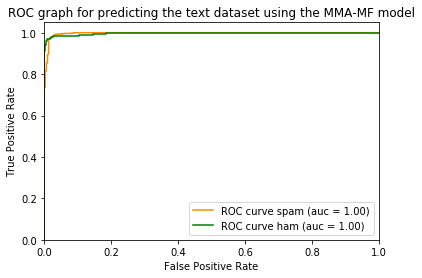

In [15]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

n_classes=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])   
    roc_auc[i] = auc(fpr[i], tpr[i])   

# #Plot of a ROC curve for a specific class
# plt.rcParams['figure.figsize']=(8,5)
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve spam (auc = %0.2f)' % roc_auc[1])
plt.plot(fpr[0], tpr[0], color='green', label='ROC curve ham (auc = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC graph for predicting the text dataset using the MMA-MF model')  
plt.legend(loc="lower right")
plt.savefig('/home/zsj/luoyang/spam_final/spam-experiment-paper/ROC_graph_for_Text.png')
plt.show()